In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_20newsgroups

seed = 1
data = fetch_20newsgroups(random_state=seed)
print(data.data[0])

From: ab4z@Virginia.EDU ("Andi Beyer")
Subject: Re: Israeli Terrorism
Organization: University of Virginia
Lines: 15

Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.



In [3]:
import keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
!pip install stop-words

In [4]:
import stop_words
import string
import re

regex = re.compile('[%s]' % re.escape(string.punctuation))
stopwords = stop_words.get_stop_words('english')

def preprocess(text):
  text = '\n'.join(text.split('\n')[5:]) # remove header
  text = regex.sub(" ", text) # remove punctuation
  for word in stopwords:
    text = text.replace(" " + word + " ", " ")
  return ''.join([char for char in text if not char.isdigit()])

print(preprocess(data.data[0].lower()))

well m sure story nad seem biased  what
i disagree statement u s  media to
ruin israels reputation  rediculous  u s  media is
the pro israeli media world  lived europe
i realize incidences one described the
letter occured  u s  media whole seem try to
ignore  u s  subsidizing israels existance the
europeans  least degree   think
that might reason report clearly the
atrocities 
	what shame austria  daily reports of
the inhuman acts commited israeli soldiers blessing
received government makes holocaust guilt
go away   look jews treating races
when got power  unfortunate 



In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

vocabulary_size = 5000
length = 300

documents = pad_sequences([
    one_hot(preprocess(text.lower()), vocabulary_size) for text in data.data
], maxlen=length, padding='post')

train_X, test_X, train_y, test_y = train_test_split(
    documents, keras.utils.to_categorical(data.target),
    random_state=seed, test_size=0.25, shuffle=True,
    stratify=keras.utils.to_categorical(data.target)
)

In [6]:
def create_model():
  keras.backend.clear_session()
  
  model = keras.Sequential()
  model.add(keras.layers.Embedding(vocabulary_size, 80, input_length=length))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(160, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(160, activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(160, activation='relu', kernel_regularizer='l2'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dense(len(pd.unique(data.target)), activation='softmax', use_bias=False))
  
  model.compile(
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy'],
      optimizer='rmsprop'
  )
  
  return model

create_model().summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 80)           400000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 24000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               3840160   
_________________________________________________________________
dropout_2 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)      

In [7]:
model = create_model()

model.fit(
    train_X, train_y,
    validation_data=(test_X, test_y),
    epochs=50,
    batch_size=2000,
    verbose=1,
    shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Train on 8485 samples, validate on 2829 samples
Epoch 1/50
8485/8485 [==============================] - 7s 878us/step - loss: 4.9849 - categorical_accuracy: 0.0497 - val_loss: 4.4168 - val_categorical_accuracy: 0.0562
Epoch 2/50
8485/8485 [==============================] - 7s 790us/step - loss: 4.6361 - categorical_accuracy: 0.0588 - val_loss: 4.3047 - val_categorical_accuracy: 0.0442
Epoch 3/50
8485/8485 [==============================] - 7s 781us/step - loss: 4.2780 - categorical_accuracy: 0.0659 - val_loss: 4.1967 - val_categorical_accuracy: 0.0548
Epoch 4/50
8485/8485 [==============================] - 7s 789us/step - loss: 4.0877 - categorical_accuracy: 0.0767 - val_loss: 4.0682 - val_categorical_accuracy: 0.0661
Epoch 5/50
8485/8485 [==============================] - 7s 790us/step - loss: 3.9565 - categorical_accuracy: 0.0906 - val_loss: 3.9646 - val_categorical_accuracy: 0.0682
Epoch 6/50
8485/8485 [==============================] 

In [0]:
clusterer = keras.backend.function([model.layers[0].input], [model.layers[-2].output])
checks = clusterer([test_X])[0]
assert len(checks) == len(test_y)

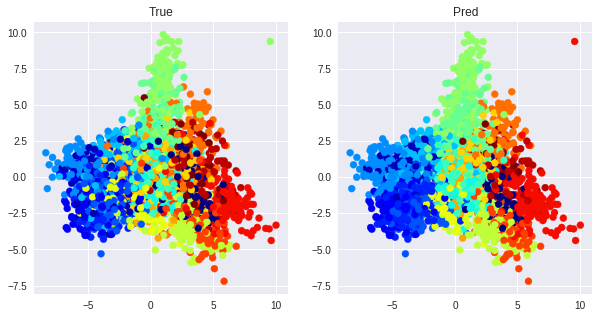

In [9]:
from sklearn.decomposition import PCA

axes = PCA(2, random_state=seed).fit_transform(checks)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('True')
ax[0].scatter(x=axes.T[0], y=axes.T[1], c=np.argmax(test_y, axis=1), cmap='jet')
ax[1].set_title('Pred')
ax[1].scatter(x=axes.T[0], y=axes.T[1], c=np.argmax(model.predict(test_X), axis=1), cmap='jet');

In [10]:
print(classification_report(np.argmax(test_y, axis=1), np.argmax(model.predict(test_X), axis=1)))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67       120
           1       0.46      0.36      0.41       146
           2       0.69      0.58      0.63       148
           3       0.36      0.60      0.45       148
           4       0.47      0.47      0.47       144
           5       0.51      0.74      0.61       148
           6       0.59      0.60      0.60       146
           7       0.47      0.51      0.49       149
           8       0.47      0.74      0.57       150
           9       0.53      0.74      0.62       149
          10       0.81      0.75      0.78       150
          11       0.74      0.74      0.74       149
          12       0.36      0.30      0.33       148
          13       0.53      0.41      0.46       149
          14       0.79      0.57      0.66       148
          15       0.74      0.57      0.65       150
          16       0.77      0.54      0.64       136
          17       0.70    